In [1]:
import numpy as np
import pandas as pd

In [2]:
import json
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px

In [4]:
%matplotlib inline

plt.style.use('seaborn')

mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = [15, 10]
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# Loading the data

In [5]:
listings = pd.read_csv('../data/listings-detailed.csv')

In [6]:
pp.pprint(listings.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

### Some routine formatting

In [7]:
# Convert dates and datetimes to pandas.DateTime
def format_dates(df: pd.DataFrame, feature: str, format: str = '%Y-%m-%d'):
    df[feature] = pd.to_datetime(df[feature], format=format)
    
# Format price by removing commas and dollar sign
def format_price(price: str):
    return float(price[1:].replace(',', ''))

def find_type(property_type: str):
    
    if 'entire' in property_type.lower():
        return 'place'
    
    if 'room' in property_type.lower():
        return 'room'
    
    return 'other'

In [8]:
dated_features = ['last_scraped', 'host_since', 'calendar_last_scraped', 
                  'first_review', 'last_review']

timestamped_features = ['scrape_id']

for feature in dated_features:
    format_dates(listings, feature)
    
for feature in timestamped_features:
    format_dates(listings, feature, format='%Y%m%d%H%M%S')
    
listings['price'] = listings.price.apply(format_price)
listings['amenities_count'] = listings.amenities.apply(lambda a: len(a))
listings['type'] = listings.property_type.apply(find_type)

### Profile of the listings using pandas profiler
This part of the code is commented as it takes a while to run and generates a separate html file. It remains here for reference.

In [9]:
# from pandas_profiling import ProfileReport

# profile = ProfileReport(listings, title="Listings", explorative=True)
# profile.to_file("listings-profile.html")

### Pair plot of some variables of interest

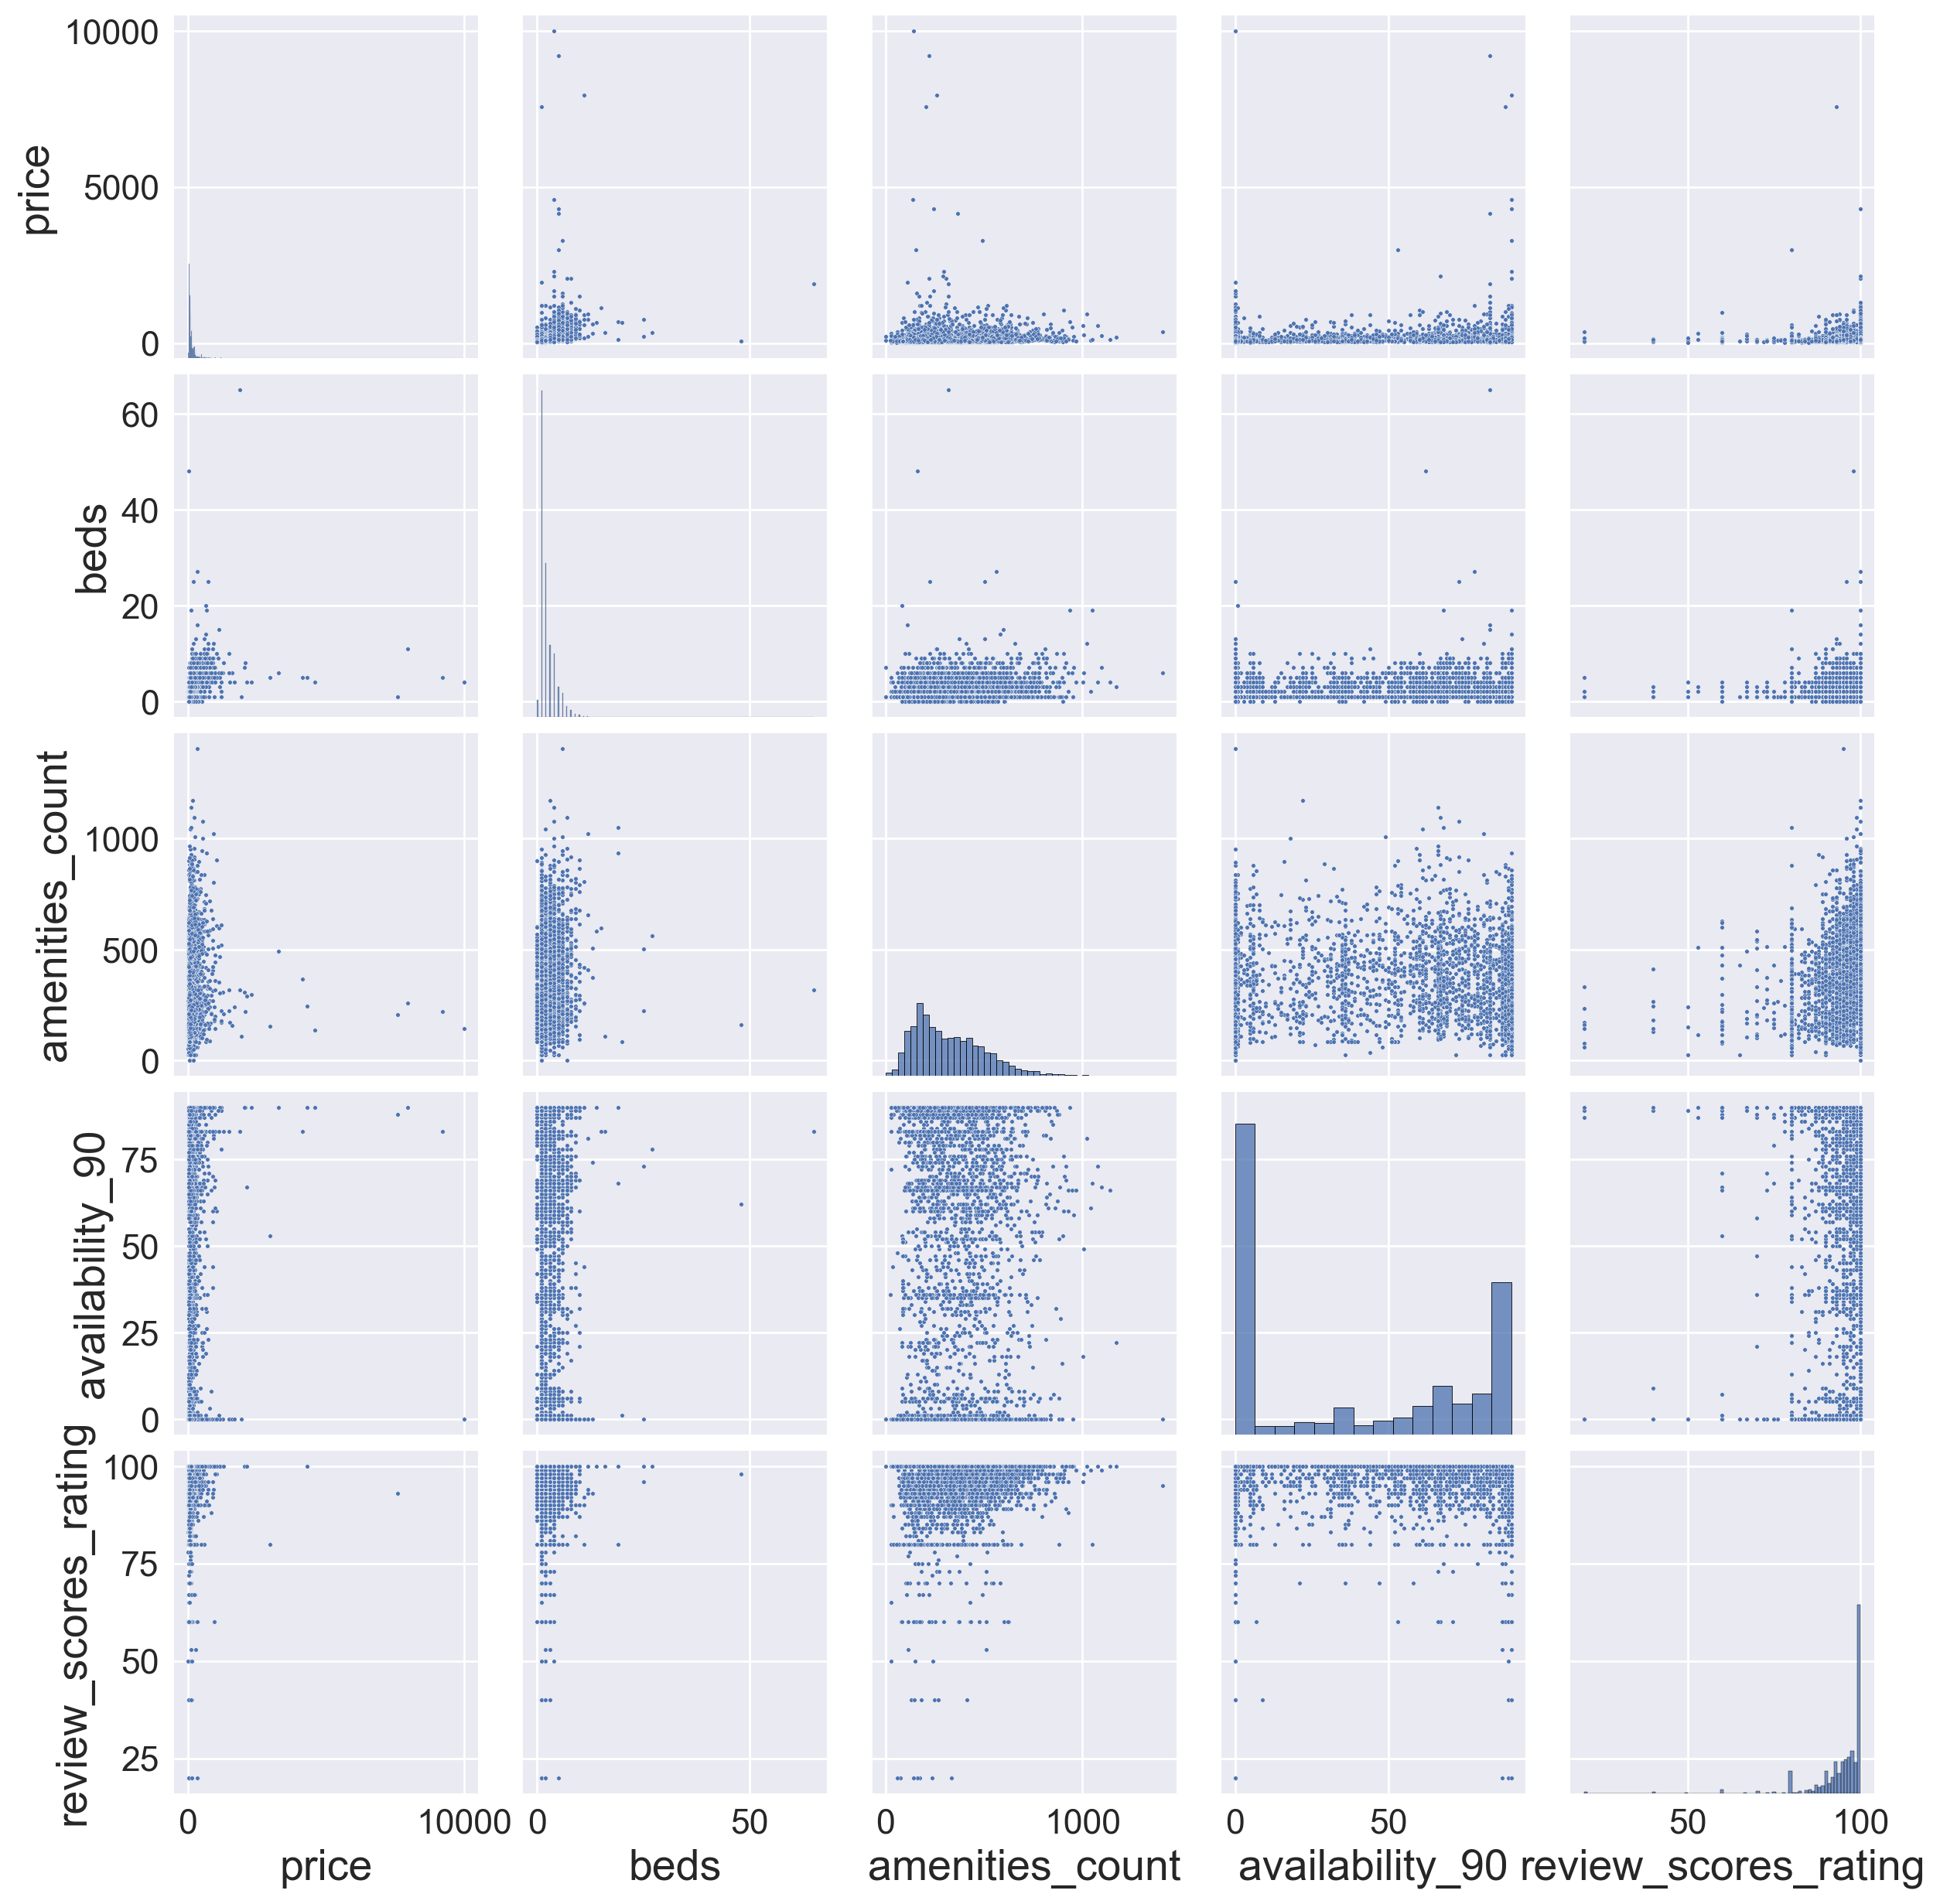

In [10]:
sns.pairplot(listings[['price', 'beds', 'amenities_count', 'availability_90', 'review_scores_rating']])

plt.show()

### What's the most common property type?

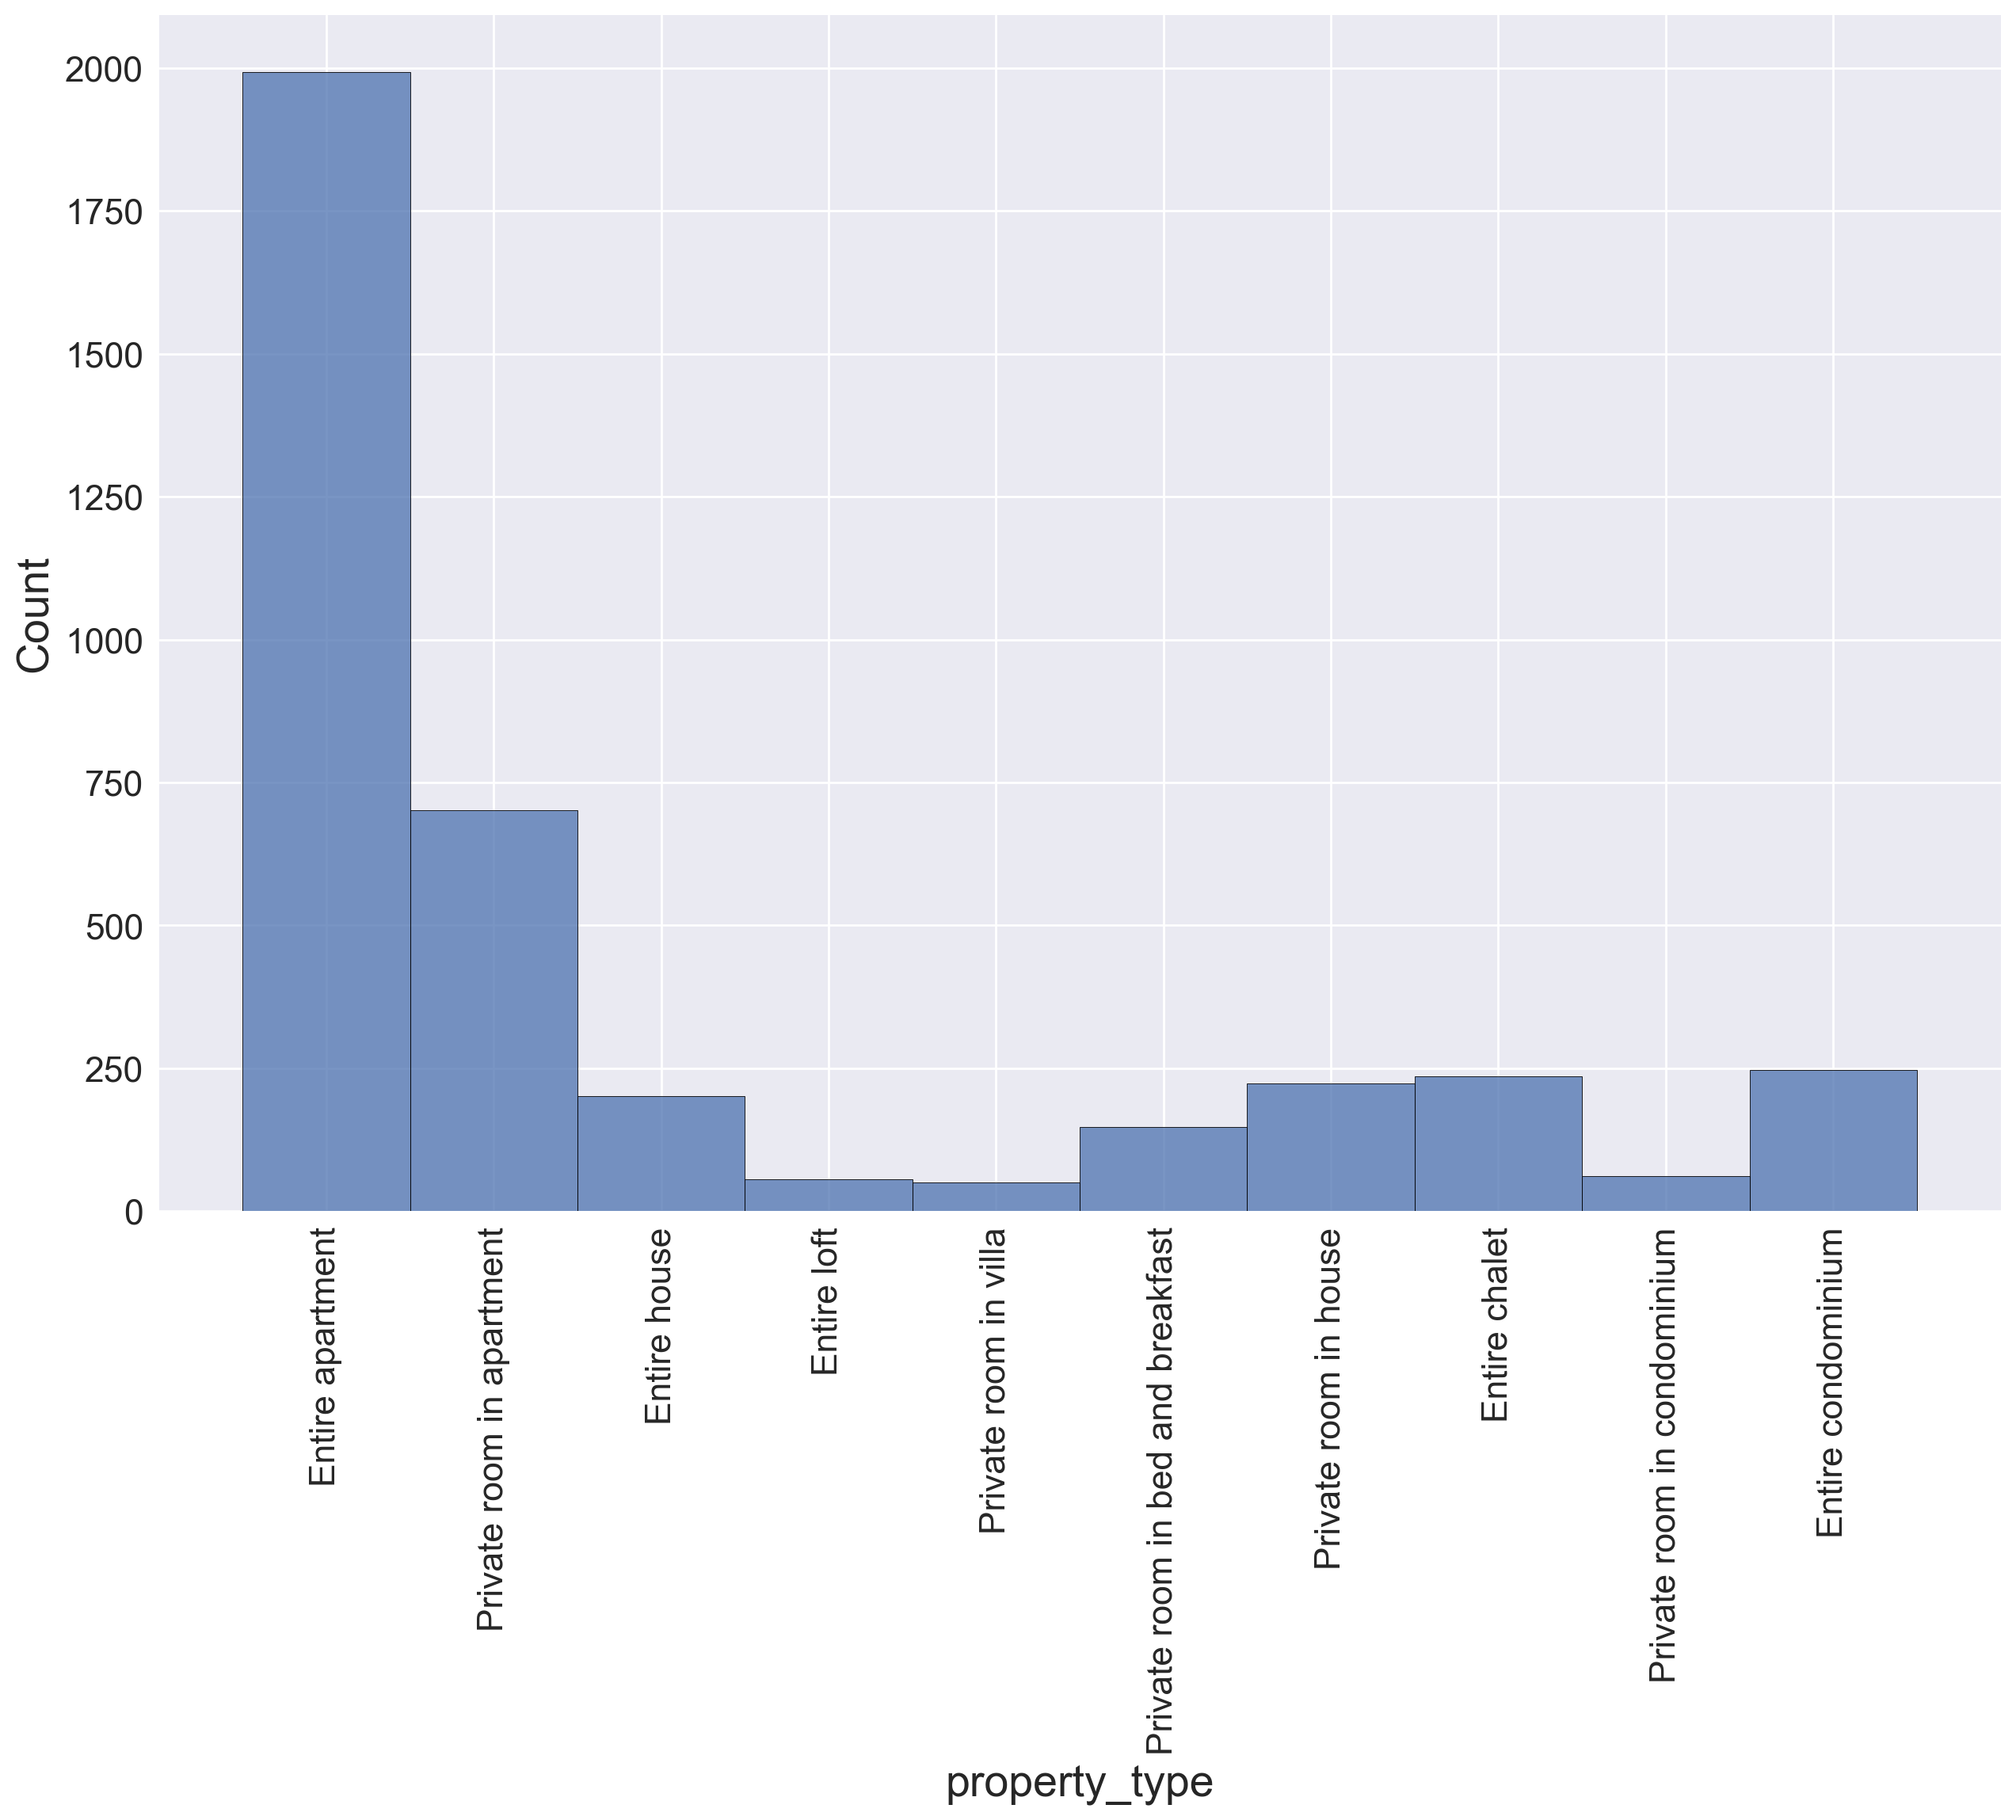

In [11]:
h = sns.histplot(listings[listings.property_type.isin(listings['property_type'].value_counts().keys()[:10])], x='property_type')

plt.xticks(rotation=90)
plt.show()

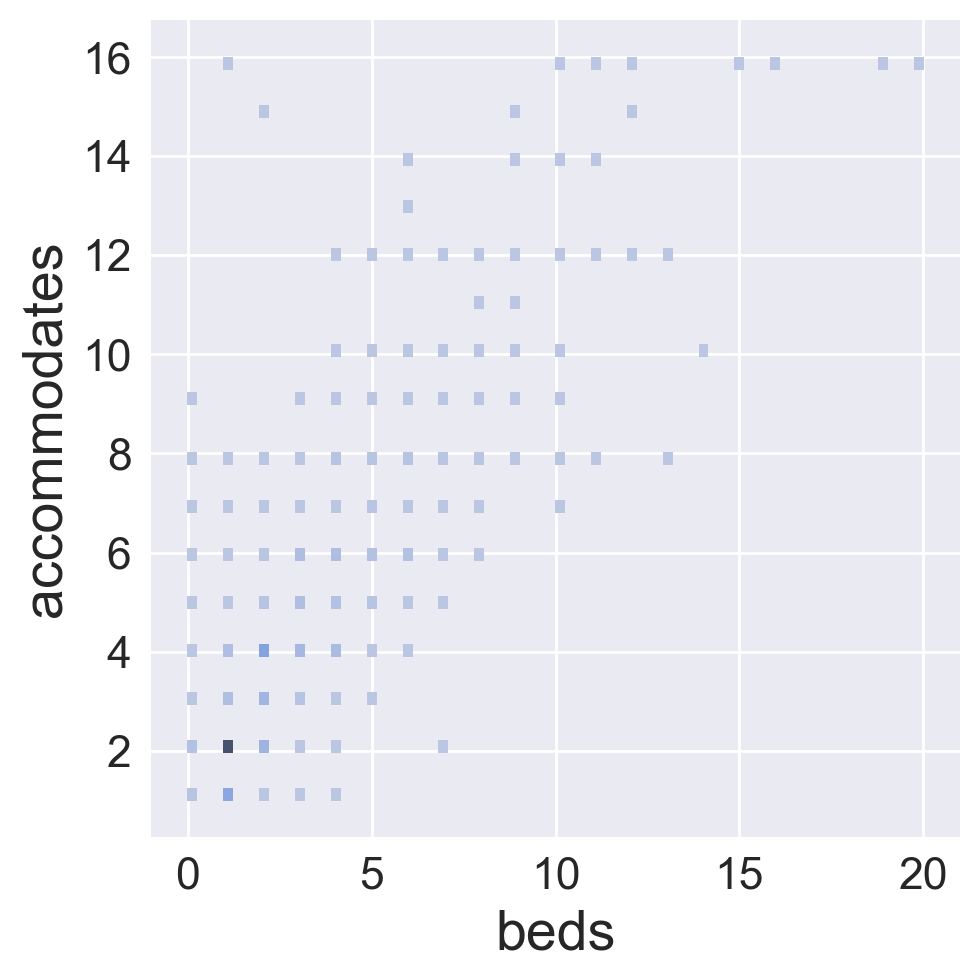

In [12]:
sns.displot(listings[listings.beds < 25], x="beds", y="accommodates")

plt.show()

### How does price distribution vary between entire places and private rooms?

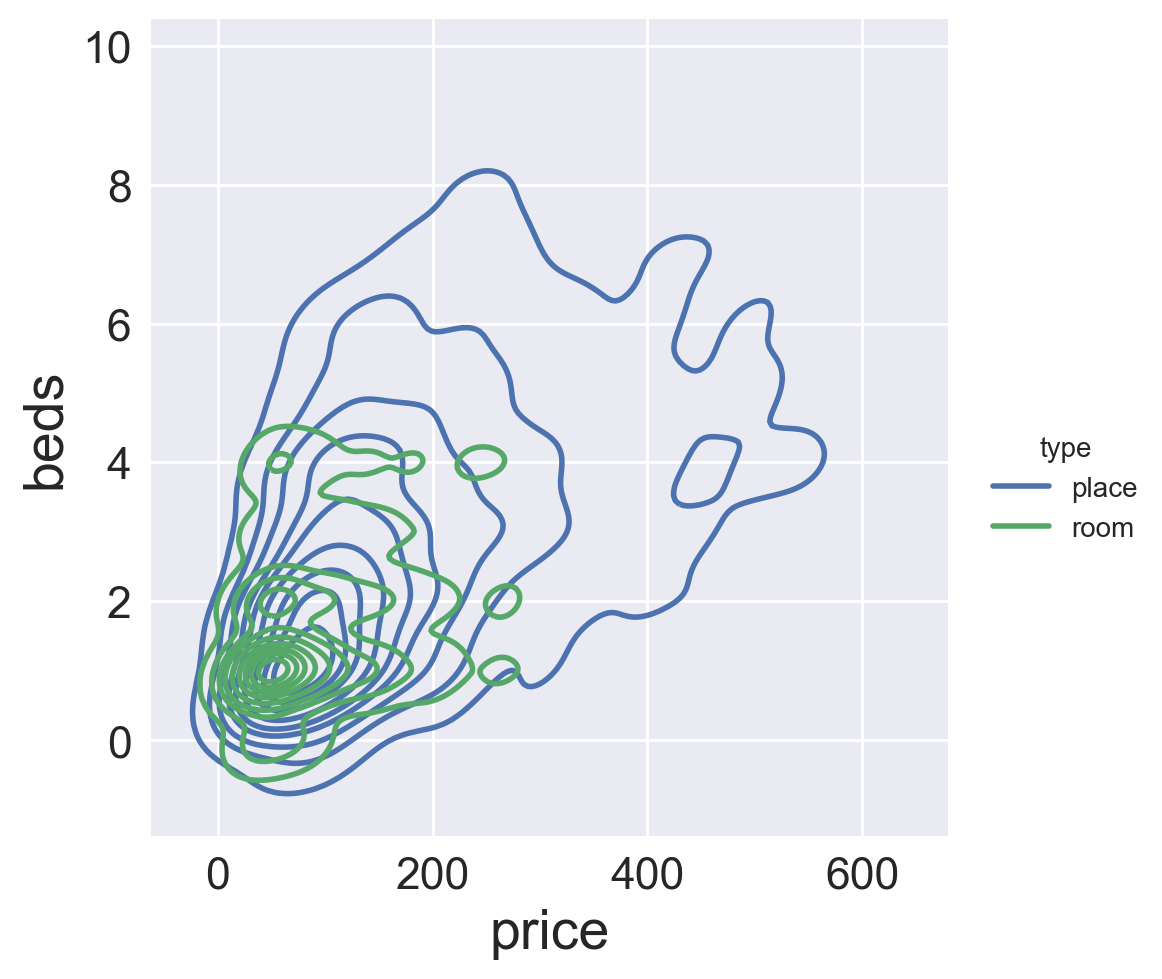

In [13]:
sns.displot(listings[(listings.price < 600) & (listings.beds < 10) & (listings.type.isin(['place', 'room']))], x="price", y="beds", hue="type", kind="kde", fill=False, common_norm=False)

plt.show()

<AxesSubplot:xlabel='review_scores_location', ylabel='Count'>

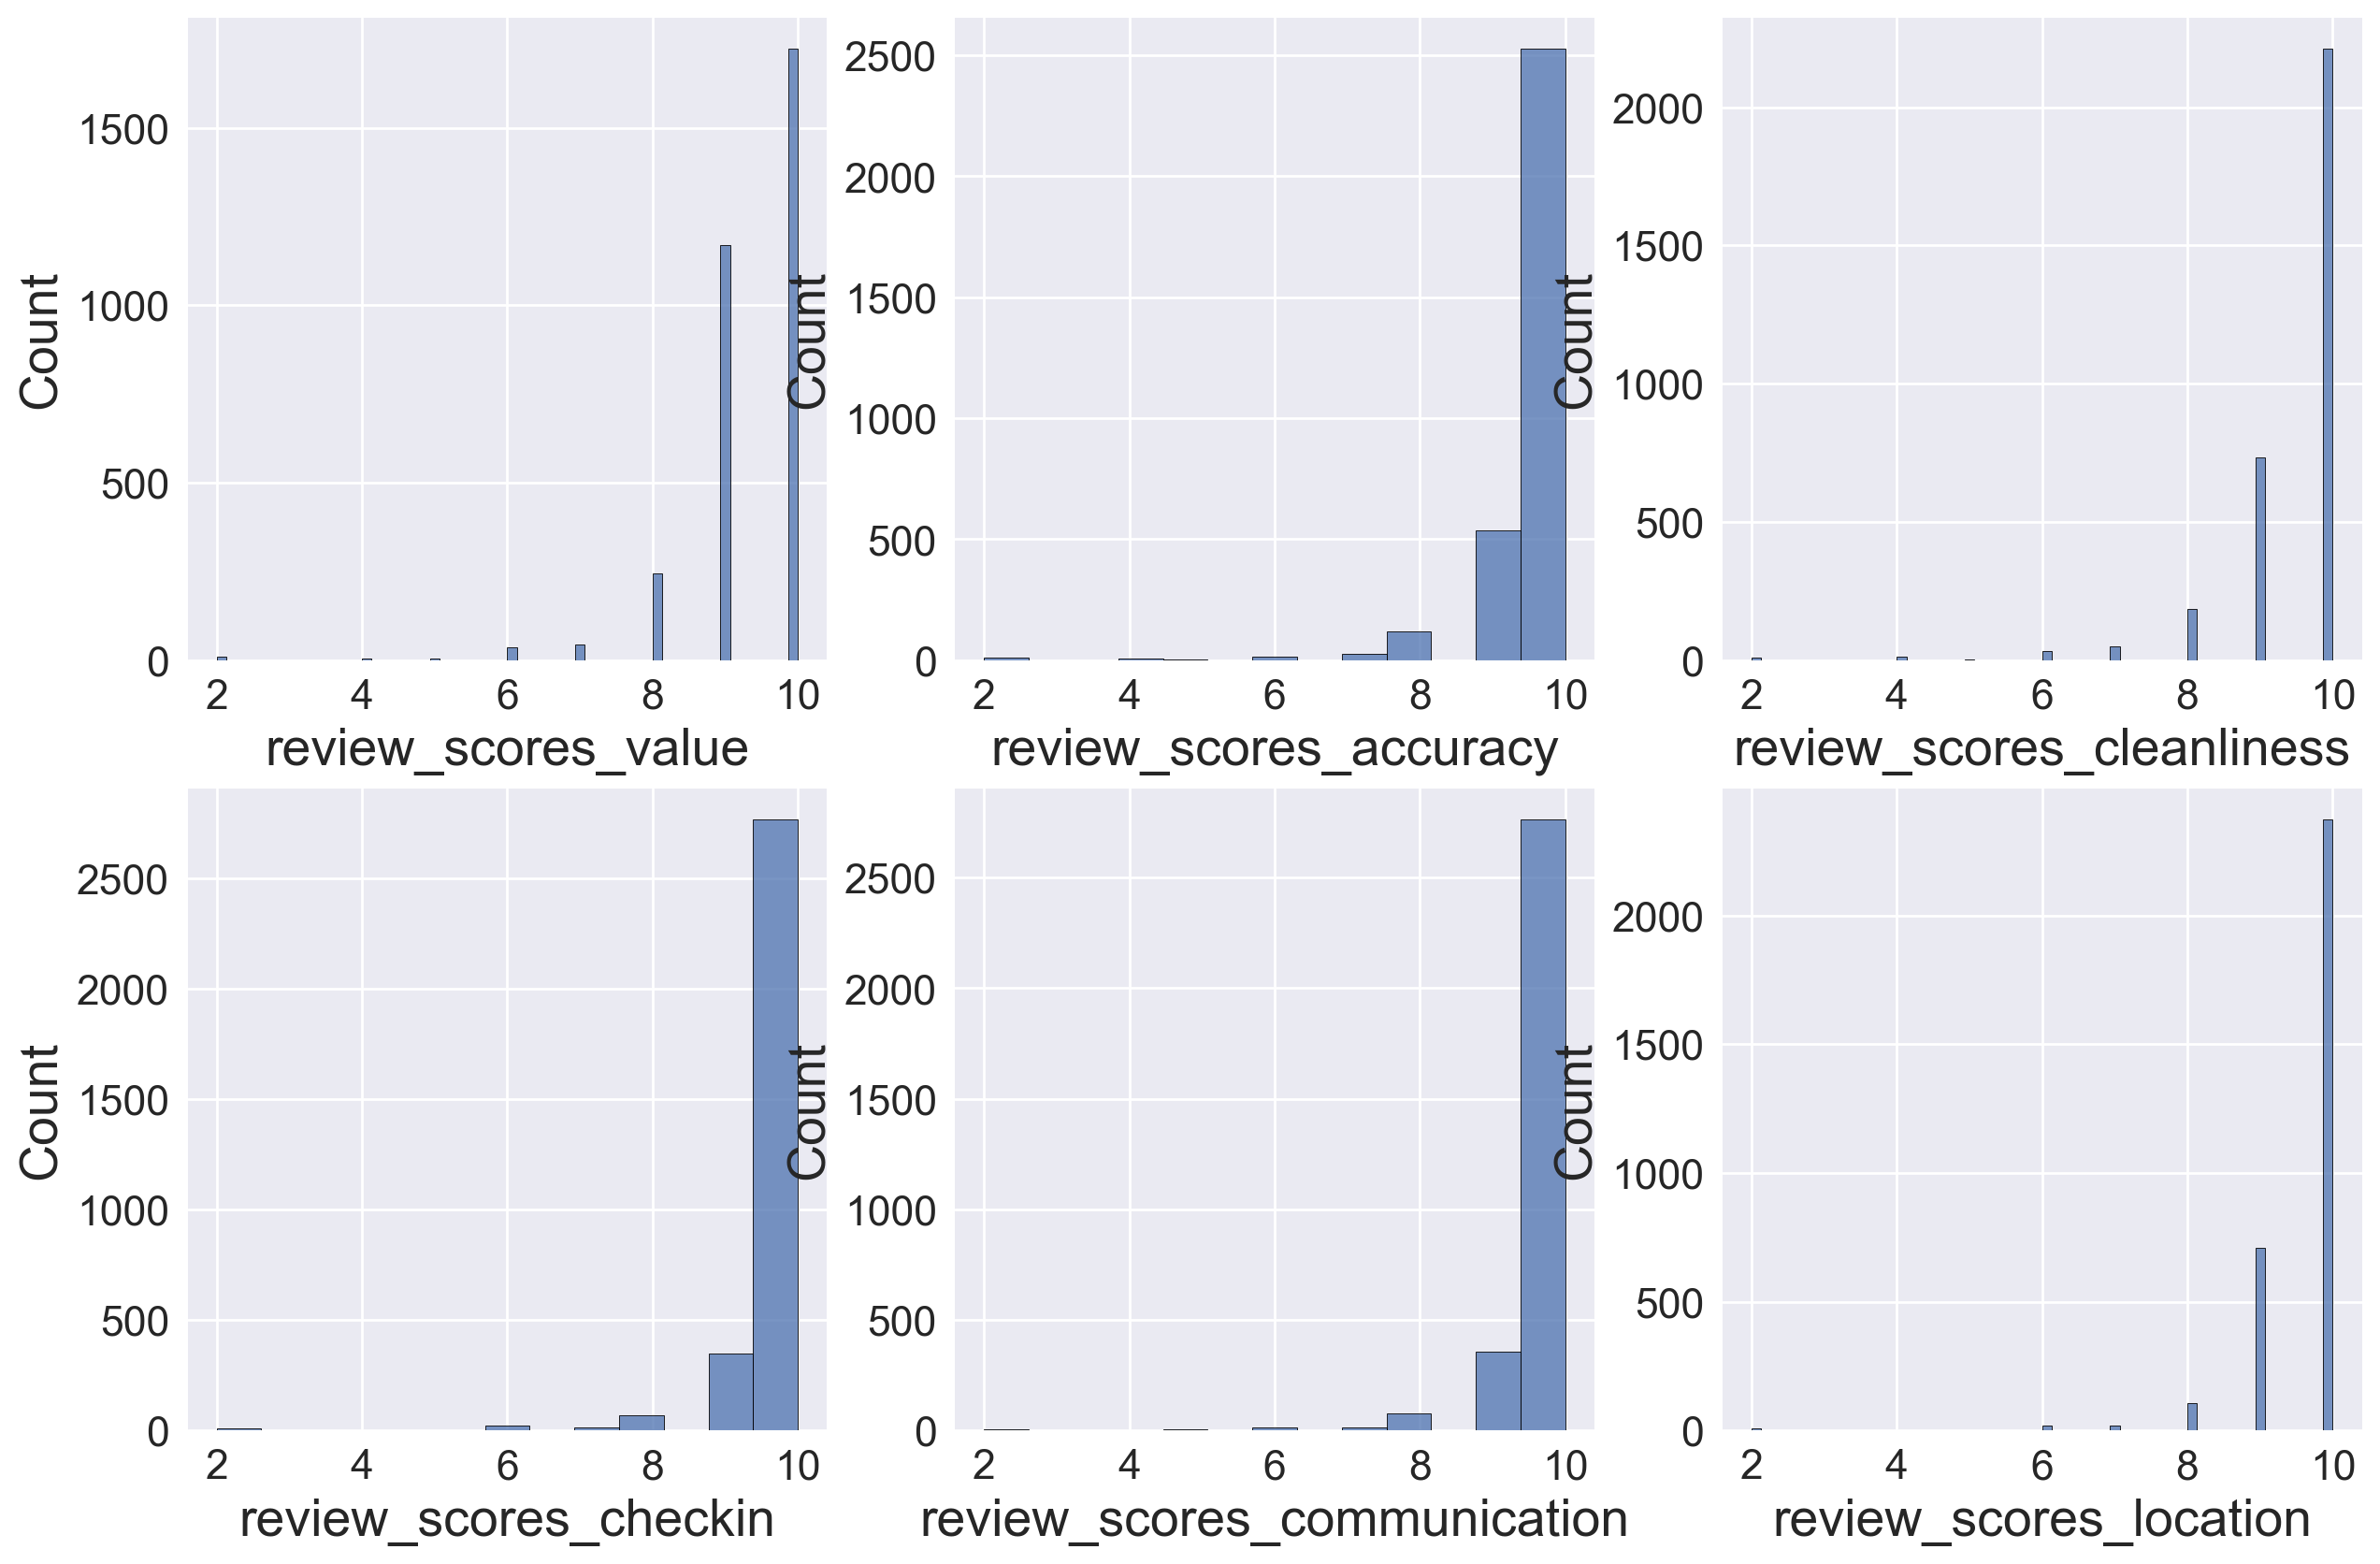

In [36]:
# 'review_scores_rating', 'review_scores_accuracy',
#        'review_scores_cleanliness', 'review_scores_checkin',
#        'review_scores_communication', 'review_scores_location',
#        'review_scores_value'

f, a = plt.subplots(2, 3)
    
sns.histplot(listings, x='review_scores_value',         ax=a[0, 0])
sns.histplot(listings, x='review_scores_accuracy',      ax=a[0, 1])
sns.histplot(listings, x='review_scores_cleanliness',   ax=a[0, 2])
sns.histplot(listings, x='review_scores_checkin',       ax=a[1, 0])
sns.histplot(listings, x='review_scores_communication', ax=a[1, 1])
sns.histplot(listings, x='review_scores_location',      ax=a[1, 2])

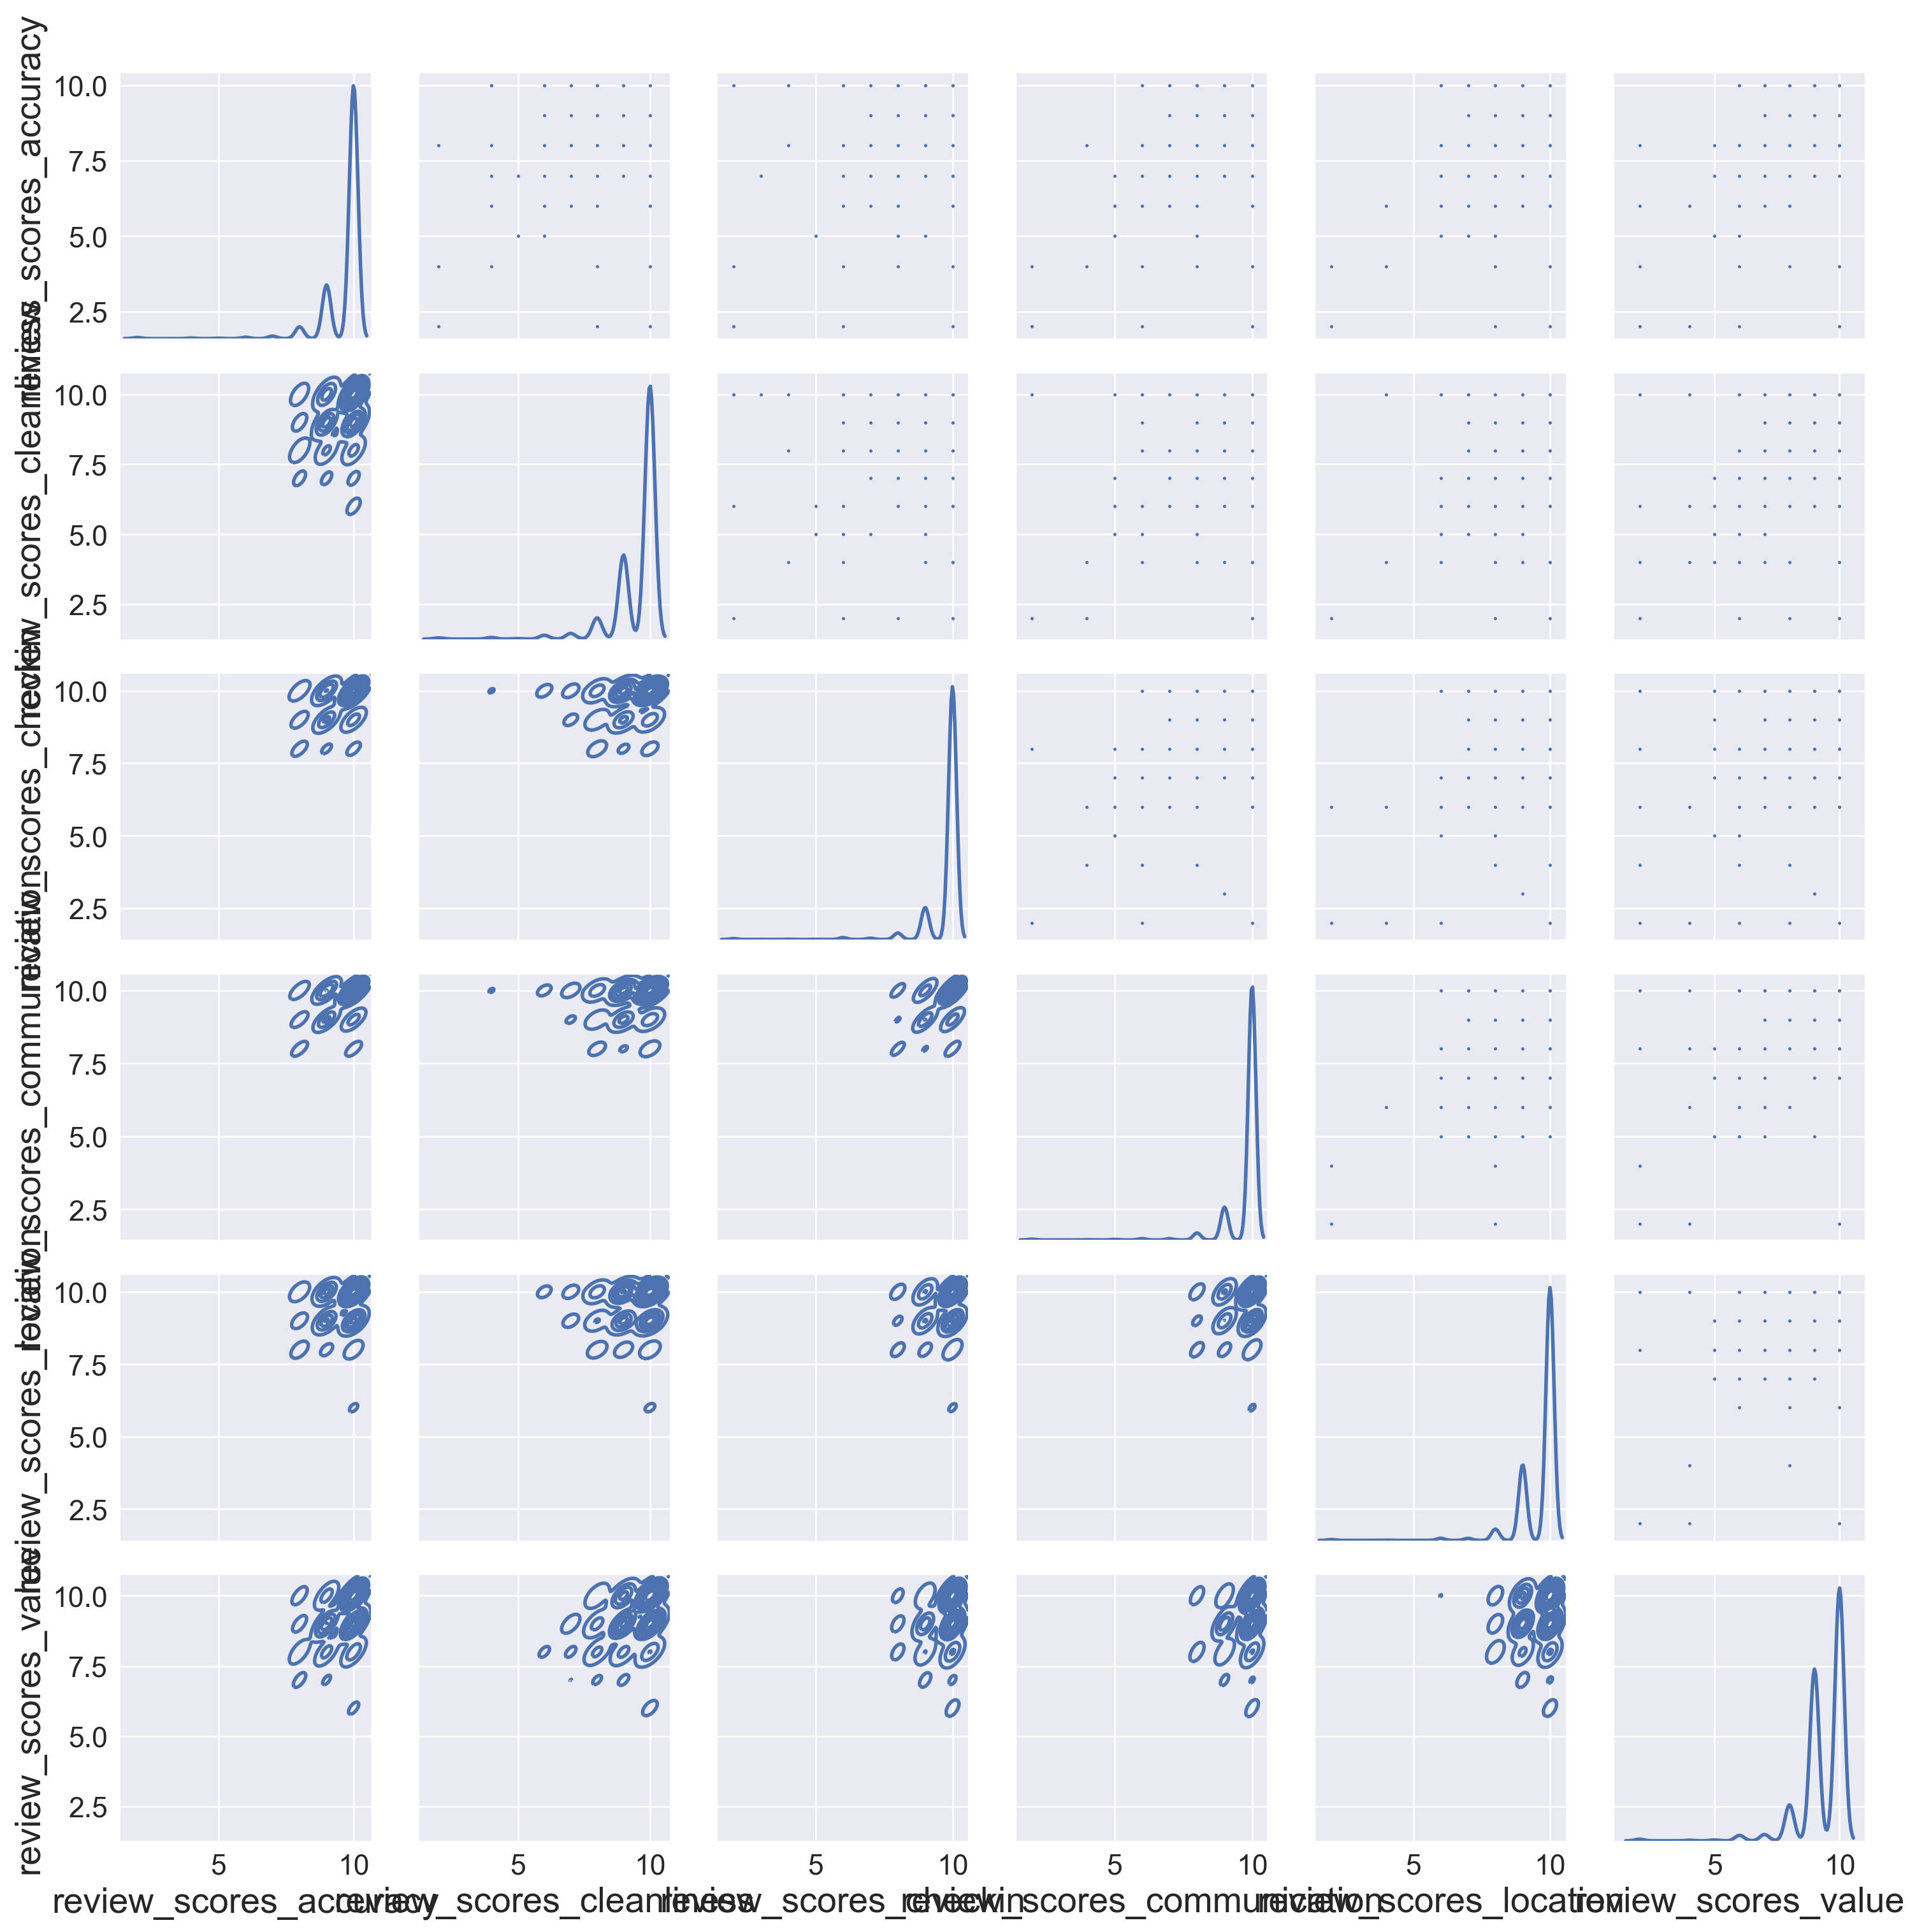

In [41]:
g = sns.PairGrid(listings[['review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']],  diag_sharey=False)

g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)